In [1]:
from core.quantum_error_correction_code import SurfaceCode

import jax.numpy as jnp
from jax import vmap, random
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.stats import beta

from pymatching import Matching

key = random.key(42)

In [2]:
def get_data(
    data_key,
    batch_size: int,
    code: SurfaceCode,
    parity_info: tuple[jnp.ndarray],
    error_probs: jnp.ndarray,
) -> tuple[jnp.ndarray, jnp.ndarray, jnp.ndarray, any]:
    data_key = random.split(data_key, num=batch_size+1)
    errors = vmap(
        code.error,
        in_axes=(0, None),
        out_axes=0
    )(data_key[:-1], error_probs)
    imgs, logicals = vmap(
        code.syndrome_img,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    syndromes, _ = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(errors, parity_info)
    return imgs[:,None,:,:], syndromes, logicals, data_key[-1]

def logicals_of_recovery(
    recovery: jnp.ndarray,
    code: SurfaceCode,
    parity_info: tuple[jnp.ndarray],
) -> jnp.ndarray:
    _, logicals = vmap(
        code.syndrome,
        in_axes=(0, None),
        out_axes=0
    )(recovery, parity_info)
    return logicals

def deform_recovery_batch(
    recovery: jnp.ndarray,
    deformation: jnp.ndarray,
):
    def _deform_recovery(
        recovery = jnp.ndarray,
    ):
        inv_transformations = jnp.array([
            [[1, 0], [0, 1]],  # I
            [[1, 1], [0, 1]],  # X-Y
            [[1, 0], [1, 1]],  # Y-Z
            [[0, 1], [1, 0]],  # X-Z
            [[0, 1], [1, 1]],  # X-Y-Z
            [[1, 1], [1, 0]],  # X-Z-Y
        ])

        recovery_deformed = vmap(
            lambda A, B, Di: jnp.dot(Di, jnp.stack([A, B])) % 2,
            in_axes=(0, 0, 0),
            out_axes=1
        )(
            recovery[0],
            recovery[1],
            inv_transformations[deformation]
        )

        return recovery_deformed
    
    return vmap(_deform_recovery)(recovery)

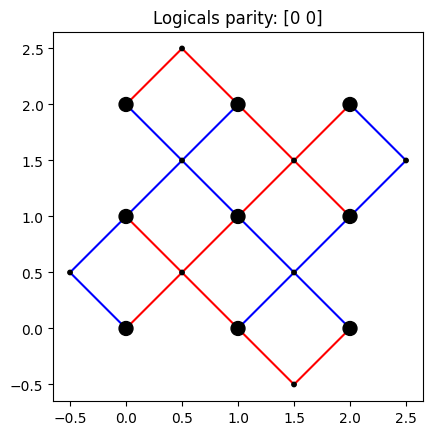

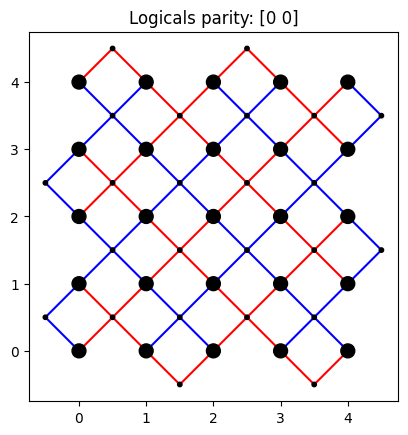

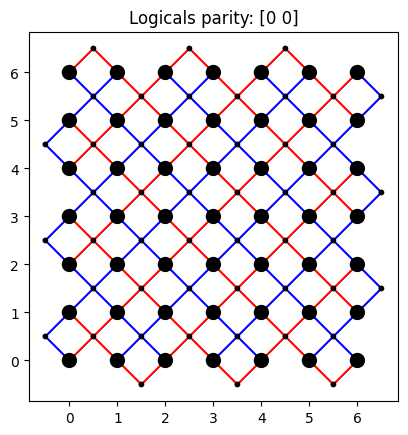

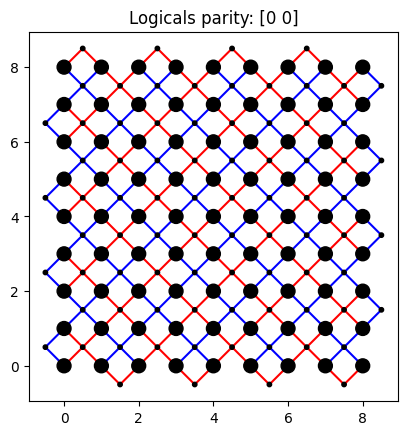

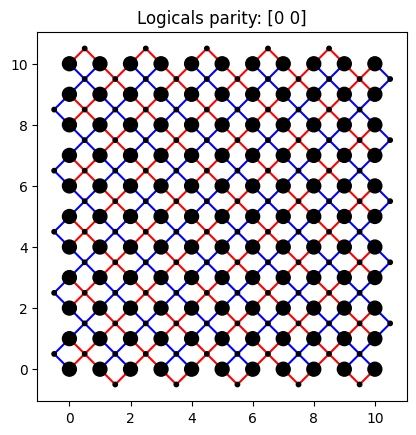

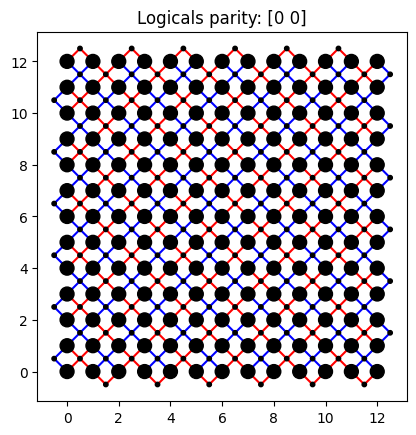

In [3]:
batch_size=50_000
err_physical = jnp.linspace(0, .2, 50)
# err_physical = jnp.logspace(-3, jnp.log10(.2), 10)
distances = jnp.arange(3, 14, 2)
err_logical_count = jnp.empty((distances.shape[0], err_physical.shape[0]))
for j, l in enumerate(distances):

    code = SurfaceCode(L=l)
    deformation = jnp.zeros(code.num_data_qubits, dtype=jnp.int32)
    parity_info = code.deformation_parity_info(deformation)
    code.show(parity_info)

    for i, p in enumerate(err_physical):
        imgs, syndromes, logicals, key = get_data(
            key, 
            batch_size, 
            code=code,
            parity_info=parity_info,
            error_probs=jnp.array([p/3, p/3, p/3])
        )

        matcher = Matching(
            jnp.append(code.hx_original, code.hz_original, axis=1)
        )
        recovery = matcher.decode_batch(syndromes)
        recovery = recovery.reshape((recovery.shape[0], 2, recovery.shape[1]//2))
        recovery = deform_recovery_batch(recovery, deformation)
        mwpm_logicals = logicals_of_recovery(recovery, code, parity_info)

        err_logical_count = err_logical_count.at[j,i].set(
            (logicals != mwpm_logicals).any(axis=1).sum()
        )

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


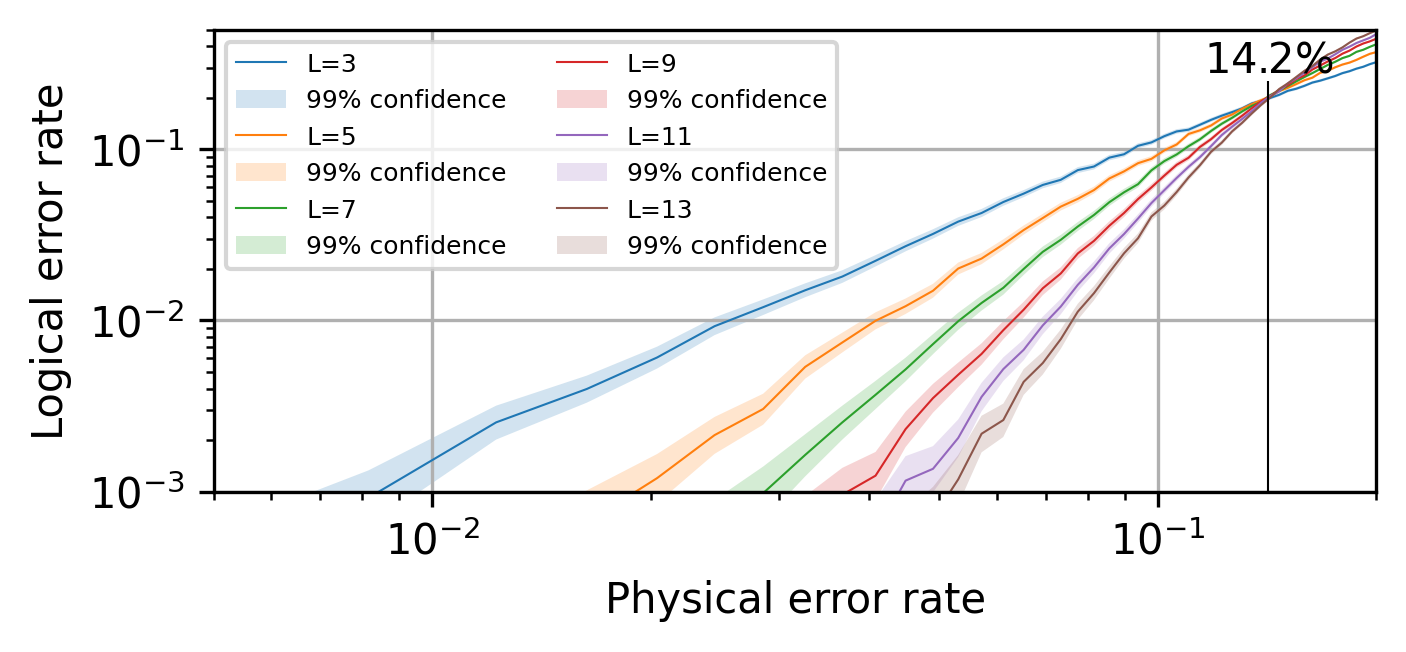

In [12]:
plt.figure(figsize=(5, 2), dpi=300)

for j, l in enumerate(distances):
    # Compute mean logical error rate
    mean = err_logical_count[j] / batch_size

    # Estimate variance using Beta distribution (assuming alpha=successes+1, beta=failures+1)
    alpha_param = err_logical_count[j] + 1
    beta_param = batch_size - err_logical_count[j] + 1
    dist = beta(alpha_param, beta_param)

    # Plot mean logical error rate
    plt.plot(err_physical, mean, '-', lw=0.5, label=f"L={l}")

    # Plot shaded region for standard deviation
    plt.fill_between(err_physical, dist.ppf(.005), dist.ppf(.995), alpha=.2, label=f"99% confidence")

plt.vlines([.142], [0], [.25], 'k', lw=.5)
plt.text(.142, .25, "$14.2\\%$", va='bottom', ha='center', fontsize=10)

plt.legend(fontsize=6, ncols=2)
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1.0))
# plt.xlim(err_physical.min(), err_physical.max())
# plt.ylim(0, .5)
plt.xlim(5E-3, .2)
plt.ylim(1E-3, .5)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Physical error rate")
plt.ylabel("Logical error rate")
plt.grid()

plt.savefig(f"figs/thresshold_estimate_standard.eps", bbox_inches='tight')
plt.savefig(f"figs/thresshold_estimate_standard.pdf", bbox_inches='tight')
plt.savefig(f"figs/thresshold_estimate_standard.png", bbox_inches='tight')

plt.show()

In [5]:
# plt.figure(figsize=(5, 2), dpi=300)

# for j, l in enumerate(distances):
#     # Compute mean logical error rate
#     mean = err_logical_count[j] / batch_size

#     # Estimate variance using Beta distribution (assuming alpha=successes+1, beta=failures+1)
#     alpha_param = err_logical_count[j] + 1
#     beta_param = batch_size - err_logical_count[j] + 1
#     dist = beta(alpha_param, beta_param)

#     # Plot mean logical error rate
#     plt.errorbar(
#         err_physical, 
#         mean, 
#         yerr=(
#             jnp.abs(dist.ppf(.005)-mean), 
#             jnp.abs(dist.ppf(.995)-mean)
#         ),
#         fmt='.',
#         lw=.5,
#         ms=2,
#         elinewidth=.5,
#         capsize=2,
#         capthick=.5,
#         label=f"L={l}"
#     )

# # plt.plot(err_physical, err_physical, 'k', lw=.5)
# plt.vlines([.14], [0], [.42], 'k', lw=.5)
# plt.text(.14, .42, "$p_{th}=14\\%$", va='bottom', fontsize=10)
# plt.legend(ncols=2)
# plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1.0))
# plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0, xmax=1.0))
# plt.xlim(err_physical.min(), err_physical.max())
# plt.ylim(0, .5)
# # plt.yscale('log')
# plt.xlabel("Physical error rate")
# plt.ylabel("Logical error rate")
# plt.grid()

# plt.savefig(f"figs/thresshold_estimate_standard.eps", bbox_inches='tight')
# # plt.savefig(f"figs/thresshold_estimate_standard.png", bbox_inches='tight')

# plt.show()